# Example: Integrated Center of Mass calculation

Prerequisites: 

 * A python3.7 or newer virtualenv with all requirements installed
  * LiberTEM 0.12.0 or newer
  * LiberTEM-iCoM 0.1.0 or newer
  * The dataset from https://zenodo.org/record/5113449

In [1]:
%matplotlib nbagg

In [2]:
import os
from scipy.ndimage import measurements
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import h5py

from libertem import api
from libertem.udf.com import CoMParams
from libertem_icom.udf.icom import ICoMUDF

In [3]:
%precision 3

'%.3f'

This starts a local cluster that is accessible through ``ctx``. Starting several clusters in parallel is unproblematic because each cluster is rather lightweight and relies on the host file system for caching.

In [4]:
ctx = api.Context()

If you want to run this notebook, you may need to adjust the ``emd_path`` variable and ``hdf5path`` parameter here. This example uses a local HDF5 file as input dataset.

In [5]:
data_base_path = os.environ.get("TESTDATA_BASE_PATH", "/home/alex/Data/")
ds = ctx.load('auto', path=os.path.join(data_base_path, '20200518 165148/default.hdr'))

# we could also use the new type="auto" feature:
# here, the ds_path is set automatically to the largest dataset in the HDF5 file
# ds = ctx.load('auth', path=emd_path)

(scan_y, scan_x, detector_y, detector_x) = ds.shape

Now, we create a center of mass (COM) analysis. We set the mask radius to `None` (default) to use the entire frame.

The coordinate system transformation between scna and detector is taken from the info in https://zenodo.org/record/5113449

In [6]:
udf = ICoMUDF(CoMParams(cy=126, cx=123, flip_y=True, scan_rotation=88))

We kick off the computation:

<IPython.core.display.Javascript object>


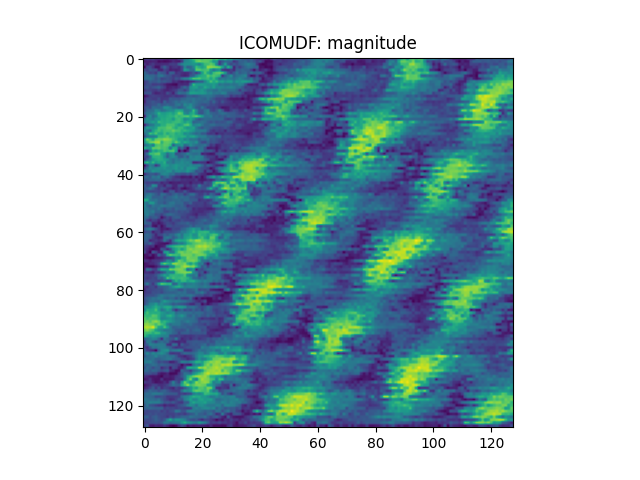

<IPython.core.display.Javascript object>


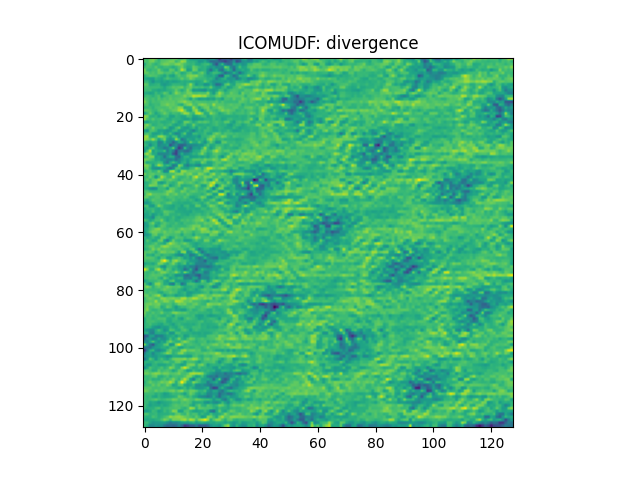

<IPython.core.display.Javascript object>


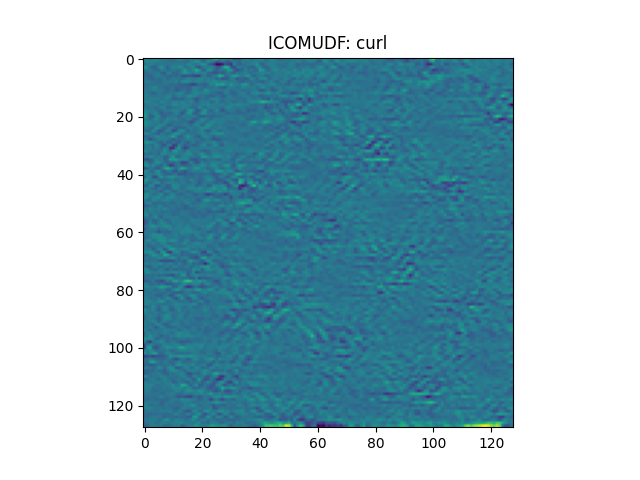

<IPython.core.display.Javascript object>


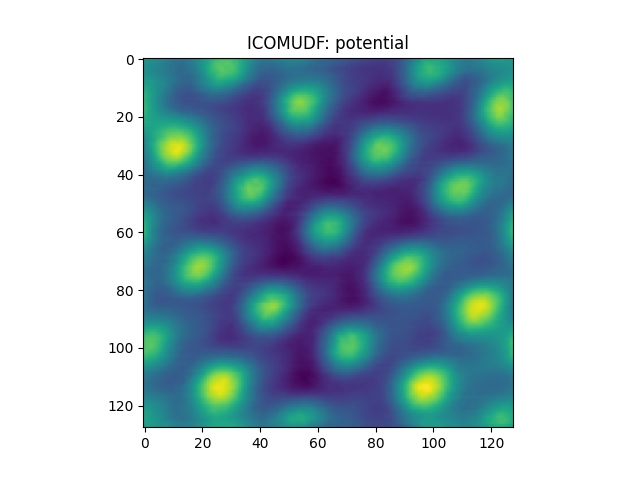

Partitions 0/8, Frames:   0%|          | 0/16384 [00:00<?, ?it/s]

CPU times: total: 406 ms
Wall time: 6.95 s


In [7]:
%time result = ctx.run_udf(dataset=ds, udf=udf, progress=True, plots=True)